In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys
import numpy as np

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.visualization import make_lupton_rgb
from astropy.utils.data import download_file, clear_download_cache

import matplotlib.pyplot as plt

In [5]:
import pandas as pd
import h5py

In [6]:
cat_fn = '/archive/k/ksf293/kavli/anomaly/data/hsc_catalogs/pdr2_wide_icmod_20.0-20.5_clean_more.csv'

In [7]:
cat = pd.read_csv(cat_fn)

In [8]:
cat

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,object_id,ra_x,dec_x,tract_x,patch_x,parent_id_x,a_g,...,r_cmodel_exp_ellipse_12,r_cmodel_dev_ellipse_11,r_cmodel_dev_ellipse_22,r_cmodel_dev_ellipse_12,r_cmodel_ellipse_11,r_cmodel_ellipse_22,r_cmodel_ellipse_12,i_cmodel_ellipse_radius,i_cmodel_ellipse_ellipticity,i_cmodel_ellipse_theta
0,0,0,0,43356767140190800,216.802789,1.510658,9858,600,0,0.100219,...,1.094012e-05,0.000053,0.000030,0.000015,0.000033,0.000037,1.168442e-05,0.009128,0.845221,6.961689
1,1,1,1,43356767140215426,216.784996,1.495341,9858,600,43356767140189984,0.099454,...,4.092161e-01,4.074245,2.506356,2.786977,2.916964,1.798599,1.991171e+00,1.822465,0.865521,-36.213899
2,2,2,2,43356767140215465,216.762722,1.495824,9858,600,43356767140190031,0.098125,...,8.705182e-02,0.513753,0.762794,0.378081,0.495782,0.735635,3.642257e-01,1.032774,0.638879,-53.610602
3,3,3,3,43356767140215565,216.882569,1.497911,9858,600,43356767140190135,0.098223,...,2.541877e-01,16.960844,15.764521,4.063465,1.023160,1.008886,2.541877e-01,1.893183,0.197258,-46.834818
4,4,4,4,43356767140215633,216.909050,1.496337,9858,600,43356767140190184,0.096049,...,-5.232369e-01,8.405349,7.994683,-5.879317,3.812341,3.629884,-2.644742e+00,2.502954,0.703243,44.031684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
942776,942776,942776,972004,43356629701261250,216.912147,1.502066,9858,500,43356629701236526,0.096200,...,2.575353e-05,0.000016,0.000044,-0.000006,0.000058,0.000083,-6.581262e-07,0.018185,0.025050,-15.937125
942777,942777,942777,972005,43356629701261405,217.048003,1.503974,9858,500,43356629701236636,0.092270,...,-5.222556e-05,0.000031,0.000272,0.000024,0.000591,0.000586,-4.996216e-05,0.024941,0.315667,70.975890
942778,942778,942778,972006,43356629701262032,216.910760,1.516211,9858,500,43356629701237404,0.096852,...,-1.909138e-08,0.000063,0.000221,-0.000092,0.000310,0.000310,-1.909138e-08,0.024844,0.043398,31.412811
942779,942779,942779,972007,43356629701262239,217.041444,1.521909,9858,500,43356629701237626,0.092717,...,7.087939e-06,0.000053,0.000141,0.000063,0.000350,0.000268,1.151602e-05,0.010326,0.299280,65.032956


In [9]:
len(cat)

942781

In [10]:
for c in cat.columns:
    if c.endswith('_x'):
        print(c)

ra_x
dec_x
tract_x
patch_x
parent_id_x


In [11]:
ra_max = 150.8
ra_min = 149.4
dec_max = 2.9
dec_min = 1.6
cat_cosmos = cat[(cat['ra_x']<ra_max) & (cat['ra_x']>ra_min)
               & (cat['dec_x']<dec_max) & (cat['dec_x']>dec_min)]

In [12]:
len(cat_cosmos)

3452

In [13]:
tag = 'gri'
imarr_fn = '../data/images_h5/images_{}.h5'.format(tag)
results_fn = '../results/results_{}.h5'.format(tag)

In [14]:
imarr = h5py.File(imarr_fn)
res = h5py.File(results_fn)

In [15]:
scores = res['anomaly_scores']
idxs = res['idxs']
object_ids = res['object_ids']
res.keys()

<KeysViewHDF5 ['anomaly_scores', 'disc_scores', 'gen_scores', 'idxs', 'object_ids', 'reconstructed']>

In [13]:
mean = np.mean(scores)
std = np.std(scores)
thresh_anom = mean+3*std

In [17]:
idxs_anom = [idxs[i] for i in range(len(scores)) if scores[i]>thresh_anom]
scores_anom = [scores[i] for i in range(len(scores)) if scores[i]>thresh_anom]

In [18]:
object_ids_anom = [object_ids[i] for i in range(len(scores)) if scores[i]>thresh_anom]

In [19]:
object_ids_anom = [int(ob) for ob in object_ids_anom]
idxs_anom = [int(idd) for idd in idxs_anom]


len(object_ids_anom)

9648

In [19]:
idxs_cosmos_anom = [idd for idd in idxs_anom if idd in cat_cosmos.index]
cat_cosmos_anom = cat_cosmos.loc[[cc for cc in cat_cosmos.index if cc in idxs_cosmos_anom]]

In [21]:
def luptonize(x):
    rgb_q = 15
    rgb_stretch = 0.5
    rgb_min = 0
    if x.ndim==3:
        x = make_lupton_rgb(x[:,:,2], x[:,:,1], x[:,:,0],
                      Q=rgb_q, stretch=rgb_stretch, minimum=rgb_min)
    elif x.ndim==4:
        x = np.array([make_lupton_rgb(xi[:,:,2], xi[:,:,1], xi[:,:,0],
                      Q=rgb_q, stretch=rgb_stretch, minimum=rgb_min)
                      for xi in x])
    else:
        raise ValueError(f"Wrong number of dimensions! Gave {x.ndim}, need 3 or 4")
    return x

In [3]:
print("ok")
print(imarr['idxs'])

ok


NameError: name 'imarr' is not defined

In [ ]:
#im_ix = np.argsort(imarr['idxs'])

In [7]:
imarr['images']

NameError: name 'imarr' is not defined

In [ ]:
im_ix_fix = im_ix[1:]
im_idxs = imarr['idxs'][:]

In [ ]:
im_ix_fix[8]
im_idxs[im_ix_fix[8]]

In [ ]:
nrows = 3
ncols = 9
fig, axarr = plt.subplots(nrows, ncols, figsize=(16, 6))
plt.subplots_adjust(hspace=0, wspace=0.1)
cc = 0
for i in range(nrows):
    for j in range(ncols):
        idx = idxs_cosmos_anom[cc]
        idx_loc = im_ix_fix[idx]
        #print(idx, idx_loc)
        idx_real = imarr['idxs'][idx_loc]
        #idx_real = imarr['idxs'].index(idx)
        #print(idx_real)
        #print(imarr['idxs'][idx_real])
        axarr[i][j].imshow(luptonize(imarr['images'][idx_loc]))
        axarr[i][j].set_xticks([])
        axarr[i][j].set_yticks([])
        cc += 1

In [ ]:
thresh_anom2 = mean+2*std
print(thresh_anom2)

In [ ]:
idxs_anom2 = [int(idxs[i]) for i in range(len(scores)) if scores[i]>thresh_anom2]
scores_anom2 = [scores[i] for i in range(len(scores)) if scores[i]>thresh_anom2]

In [ ]:
idxs_cosmos_anom2 = [idd for idd in idxs_anom2 if idd in cat_cosmos.index]
cat_cosmos_anom2 = cat_cosmos.loc[[cc for cc in cat_cosmos.index if cc in idxs_cosmos_anom2]]
len(cat_cosmos_anom2)

In [ ]:
nrows = 10
ncols = 10
fig, axarr = plt.subplots(nrows, ncols, figsize=(18, 18))
plt.subplots_adjust(hspace=0.25, wspace=0.05)
cc = 0
for i in range(nrows):
    for j in range(ncols):
        idx = idxs_cosmos_anom2[cc]
        idx_loc = im_ix_fix[idx]
        idx_real = imarr['idxs'][idx_loc]
        axarr[i][j].imshow(luptonize(imarr['images'][idx_loc]))
        axarr[i][j].set_title(cc)
        axarr[i][j].set_xticks([])
        axarr[i][j].set_yticks([])
        cc += 1

In [ ]:
plt.figure()
ax = plt.gca()
cc = 0
idx = idxs_cosmos_anom2[cc]
idx_loc = im_ix_fix[idx]
idx_real = imarr['idxs'][idx_loc]
ax.imshow(luptonize(imarr['images'][idx_loc]))
ax.set_title(cc)
ax.set_xticks([])
ax.set_yticks([])

[]

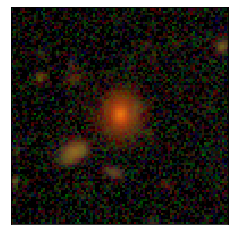

In [22]:
idxx = 0
plt.figure(figsize=(4,4))
ax = plt.gca()

#idx_loc = im_ix_fix[idxx]
#idx_real = imarr['idxs'][idx_loc]
idx_loc = idxx

ax.imshow(luptonize(imarr['images'][idx_loc]))
#ax.set_title(idxx)
ax.set_xticks([])
ax.set_yticks([])

In [19]:
from unagi import config
from unagi import hsc
from unagi.task import hsc_tricolor

In [25]:
objx = cat.iloc[8]
rax = objx['ra_x']
decx = objx['dec_x']
print(rax, decx)

216.8281045448801 1.5067854121775812


In [20]:
pdr2_wide = hsc.Hsc(dr='pdr2', rerun='pdr2_wide', config_file='../cred.dat')

# Get table list from /home/ksf293/.local/lib/python3.6/site-packages/unagi-0.1.0-py3.6.egg/unagi/data/pdr2_wide/pdr2_wide_tables.fits


In [28]:
filters = ['g','r','i']
ang_size_h = 10*u.arcsec
ang_size_w = 10*u.arcsec

coord = SkyCoord(rax, decx, frame='icrs', unit='deg')

s_ang = [ang_size_h, ang_size_w]
cutout_rgb, cutout_wcs = hsc_tricolor(
    coord, cutout_size=s_ang, filters=filters, verbose=False, 
    save_rgb=False, save_img=False, use_saved=False, archive=pdr2_wide)
print(cutout_rgb.data.shape)

error: db type is dbm.gnu, but the module is not available

In [19]:
print(imarr['idxs'][0])

8.0


In [ ]:
print(imarr['idxs'][0])